In [16]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from huggingface_hub import login
import os
from dotenv import load_dotenv
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score



In [2]:
dataset = load_dataset("jackhhao/jailbreak-classification")
# rename prompt to text and label to label
dataset = dataset.rename_column("prompt", "text")
dataset = dataset.rename_column("type", "labels")

def label_mapping(example):
    example["labels"] = 0 if example["labels"] == "benign" else 1
    return example

dataset = dataset.map(label_mapping)


In [3]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# i take this params from : https://huggingface.co/jackhhao/jailbreak-classifier
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5, # need to be changed to 5
    lr_scheduler_type="linear",
   # logging_dir="./logs",
    save_strategy="no",
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    # compute_metrics=lambda pred: {
    #     "accuracy": accuracy_score(tokenized_datasets["test"]["labels"], pred.predictions.argmax(axis=1)),
    #     "f1": f1_score(tokenized_datasets["test"]["labels"], pred.predictions.argmax(axis=1)),
    #     "recall": recall_score(tokenized_datasets["test"]["labels"], pred.predictions.argmax(axis=1)),
    #     "precision": precision_score(tokenized_datasets["test"]["labels"], pred.predictions.argmax(axis=1))
    # },
)
trainer.train()
trainer.evaluate()

/opt/anaconda3/envs/qualifier-env/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                                 
 20%|██        | 131/655 [03:38<12:46,  1.46s/it]

{'eval_loss': 0.08117879927158356, 'eval_runtime': 13.7218, 'eval_samples_per_second': 19.094, 'eval_steps_per_second': 2.405, 'epoch': 1.0}


                                                 
 40%|████      | 262/655 [06:51<07:43,  1.18s/it]

{'eval_loss': 0.01894414983689785, 'eval_runtime': 11.7107, 'eval_samples_per_second': 22.373, 'eval_steps_per_second': 2.818, 'epoch': 2.0}


                                                 
 60%|██████    | 393/655 [09:59<05:12,  1.19s/it]

{'eval_loss': 0.04414881020784378, 'eval_runtime': 11.6701, 'eval_samples_per_second': 22.451, 'eval_steps_per_second': 2.828, 'epoch': 3.0}


 76%|███████▋  | 500/655 [12:23<03:30,  1.36s/it]

{'loss': 0.0589, 'grad_norm': 0.003450758522376418, 'learning_rate': 1.1832061068702292e-05, 'epoch': 3.82}


                                                 
 80%|████████  | 524/655 [13:07<02:36,  1.20s/it]

{'eval_loss': 0.05739410221576691, 'eval_runtime': 11.7211, 'eval_samples_per_second': 22.353, 'eval_steps_per_second': 2.815, 'epoch': 4.0}


                                                 
100%|██████████| 655/655 [16:15<00:00,  1.49s/it]


{'eval_loss': 0.03022134117782116, 'eval_runtime': 11.6859, 'eval_samples_per_second': 22.42, 'eval_steps_per_second': 2.824, 'epoch': 5.0}
{'train_runtime': 975.4478, 'train_samples_per_second': 5.351, 'train_steps_per_second': 0.671, 'train_loss': 0.04502429529057659, 'epoch': 5.0}


100%|██████████| 33/33 [00:11<00:00,  2.84it/s]


{'eval_loss': 0.03022134117782116,
 'eval_runtime': 11.6856,
 'eval_samples_per_second': 22.421,
 'eval_steps_per_second': 2.824,
 'epoch': 5.0}

In [20]:
model = trainer.model

In [23]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
import torch
# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Move the model to the MPS device
model.to(device)

# Ensure model is in evaluation mode
model.eval()

# Prepare the test dataset (tokenized inputs and attention mask)
X_test = tokenized_datasets["test"]["input_ids"]
attention_mask = tokenized_datasets["test"]["attention_mask"]

# Convert input IDs and attention mask to tensors and move to device
input_ids_tensor = torch.tensor(X_test).to(device)
attention_mask_tensor = torch.tensor(attention_mask).to(device)

# Make predictions
with torch.no_grad():  # Disable gradient calculation for predictions
    outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
    logits = outputs.logits  # Get the logits from the output

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Get predicted class indices
y_pred = probabilities.argmax(dim=1)

# Get confidence scores (max probabilities)
confidence_scores = probabilities.max(dim=1).values
y_test = tokenized_datasets["test"]["labels"]


In [31]:
import numpy as np
y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else np.array(y_test)

# Move y_pred to CPU and convert to NumPy
y_pred_cpu = y_pred.cpu().numpy() if isinstance(y_pred, torch.Tensor) else np.array(y_pred)

# Calculate metrics
_f1_score = f1_score(y_test, y_pred_cpu)
_accuracy = accuracy_score(y_test, y_pred_cpu)
_recall = recall_score(y_test, y_pred_cpu)
_precision = precision_score(y_test, y_pred_cpu)

# Print results
print(f"F1 Score: {_f1_score:.4f}")
print(f"Accuracy: {_accuracy:.4f}")
print(f"Recall: {_recall:.4f}")
print(f"Precision: {_precision:.4f}")

F1 Score: 0.9964
Accuracy: 0.9962
Recall: 0.9928
Precision: 1.0000


In [35]:
tokenized_datasets["train"].features["labels"]

Value(dtype='int64', id=None)

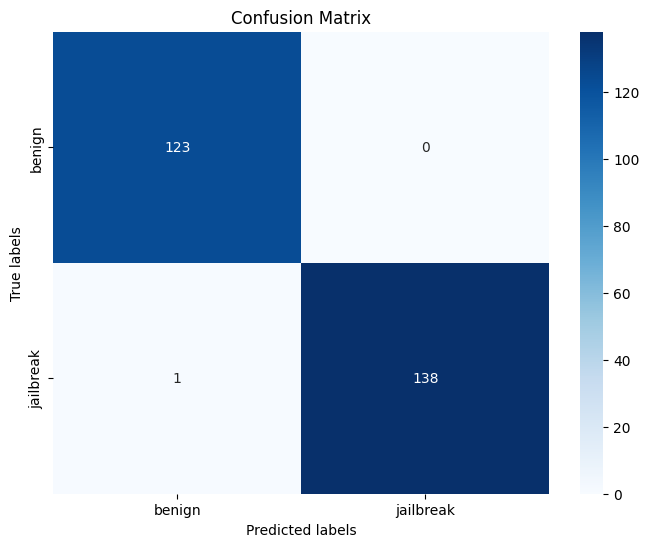

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()



# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred_cpu, labels=['benign', 'jailbreak'])


In [11]:
confidence_scores

array([4.8707523, 4.905482 , 2.9927146, 4.8796144, 5.1712136, 4.806562 ,
       4.787334 , 5.165216 , 4.6440454, 5.083199 , 5.183394 , 5.1865544,
       4.4222207, 5.171678 , 5.164742 , 4.851861 , 4.8452945, 5.17391  ,
       5.181354 , 4.79956  , 5.1443954, 5.096398 , 4.684867 , 4.8008413,
       5.1194124, 4.876776 , 5.1519737, 2.4450216, 4.7228456, 4.861794 ,
       5.167191 , 5.182709 , 5.18575  , 4.8050113, 5.121348 , 5.1663365,
       5.169514 , 5.162043 , 4.79931  , 4.7679353, 4.574017 , 4.8338294,
       4.615678 , 5.1596875, 5.108792 , 5.1753154, 5.1797223, 4.4625425,
       5.169557 , 4.788056 , 5.0899343, 5.146461 , 4.5040193, 4.057355 ,
       5.1804633, 5.17394  , 4.2604604, 4.8441305, 4.171915 , 5.1812367,
       4.7051725, 5.148735 , 4.8610587, 5.1383414, 5.030646 , 5.162043 ,
       5.1752   , 3.8808422, 3.8639603, 4.6371427, 4.8713326, 5.0048203,
       4.883825 , 4.71369  , 5.1102605, 5.195726 , 4.815122 , 5.087173 ,
       5.103885 , 4.723082 , 4.8449244, 4.717871 , 

In [ ]:
# need show results .. with confussion matrix and other metrics
# need to save model
y_probs = trainer.model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)
_f1_score = f1_score(y_test, y_pred)
_accuracy = accuracy_score(y_test, y_pred)
_recall = recall_score(y_test, y_pred)
_precision = precision_score(y_test, y_pred)
print(f"F1 Score: {_f1_score}")
print(f"Accuracy: {_accuracy}")
print(f"Recall: {_recall}")
print(f"Precision: {_precision}")

In [37]:
load_dotenv()
if 'HF_TOKEN' in os.environ:
    print("pushing to huggingface hub")
    HF_TOKEN = os.getenv("HF_TOKEN")
    login(token=HF_TOKEN)  
    model.push_to_hub("oranne55/qualifier-model3-finetune-pretrained-transformer")
    tokenizer.push_to_hub("oranne55/qualifier-model3-finetune-pretrained-transformer")

pushing to huggingface hub


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
model.safetensors: 100%|██████████| 438M/438M [00:49<00:00, 8.89MB/s] 
